# Test Simulation Methods (Equity + Options)

This notebook demonstrates how to compute **Value-at-Risk (VaR)** and **Conditional Value-at-Risk (CVaR)**  
using two simulation-based approaches:

1. **Parametric Monte Carlo simulation**
2. **Historical simulation with bootstrapping**

We apply both methods to a portfolio containing:
- **Equity positions** (real stocks: MSFT, AAPL, NVDA)
- **Derivative positions** (European options on the same stocks)

The pricing of options is based on the **Black–Scholes formula**, and the simulations use both:
- **Realistic input data** fetched from Yahoo Finance
- **Volatility and risk-free rate assumptions** for each option

We compute:
- The **P&L distribution** of the portfolio after 1-day horizon
- The associated **VaR** and **CVaR** at a specified confidence level (e.g., 95%)
- And visualize the resulting distribution for risk analysis


In [34]:
import data_download as dd
import numpy as np
import simulations_bs as sim
import matplotlib.pyplot as plt
import pandas as pd

# Form a portfolio and test Black-Scholes

In [42]:

tickers = ["MSFT", "AAPL", "NVDA"]
prices = dd.get_raw_prices(tickers, start="2024-01-01")
S0_series = prices.iloc[-1]  # Series with tickers as index
shares_eq = pd.Series([3, 2, 4], index=tickers)

# Estimate historical volatility
returns = prices.pct_change().dropna()
historical_sigma = returns.std() * np.sqrt(252)  # annualized

print("Estimated historical annualized volatility:")
for tkr in tickers:
    print(f"{tkr:5}: {historical_sigma[tkr]:.2%}")

# Define options using estimated volatility
options = [
    {
        "idx": "MSFT",
        "K": 440,
        "T": 10 / 252,
        "r": 0.01,
        "sigma": historical_sigma["MSFT"],
        "type": "call",
        "qty": 20
    },
    {
        "idx": "AAPL",
        "K": 180,
        "T": 10 / 252,
        "r": 0.01,
        "sigma": historical_sigma["AAPL"],
        "type": "put",
        "qty": 20
    }
]

# Show equity and option values 
print("\n Equity positions (latest prices):")
for tkr in tickers:
    qty = shares_eq[tkr]
    price = S0_series[tkr]
    print(f"{tkr:5}: {qty} shares x {price:.2f} = {qty * price:.2f} USD")

print("\n Option values (Black Scholes at time 0):")
total_opt_val = 0
for i, opt in enumerate(options):
    spot = S0_series[opt["idx"]]
    price_bs = sim.bs_price(spot, opt["K"], opt["T"], opt["r"], opt["sigma"], opt["type"])
    val = price_bs * opt["qty"]
    total_opt_val += val
    print(f"Option {i+1} on {opt['idx']} ({opt['type']}): "
          f"Spot={spot:.2f}, K={opt['K']:.2f}, σ={opt['sigma']:.2%} → BS = {price_bs:.2f} x {opt['qty']} = {val:.2f} USD")

# Total portfolio value
total_eq_val = (S0_series * shares_eq).sum()
total_portfolio_val = total_eq_val + total_opt_val
print(f"\n Total equity value:     {total_eq_val:.2f} USD")
print(f" Total option value:     {total_opt_val:.2f} USD")
print(f" Total portfolio value:  {total_portfolio_val:.2f} USD")


Estimated historical annualized volatility:
MSFT : 24.32%
AAPL : 30.17%
NVDA : 57.82%

 Equity positions (latest prices):
MSFT : 3 shares x 438.73 = 1316.19 USD
AAPL : 2 shares x 198.53 = 397.06 USD
NVDA : 4 shares x 116.65 = 466.60 USD

 Option values (Black Scholes at time 0):
Option 1 on MSFT (call): Spot=438.73, K=440.00, σ=24.32% → BS = 7.95 x 20 = 159.03 USD
Option 2 on AAPL (put): Spot=198.53, K=180.00, σ=30.17% → BS = 0.24 x 20 = 4.83 USD

 Total equity value:     2179.85 USD
 Total option value:     163.87 USD
 Total portfolio value:  2343.72 USD


# Single day Monte Carlo Simulations


This simulation estimates 1-day **Value-at-Risk (VaR)** and **Expected  (CVaR)** using a parametric Monte Carlo approach.

#### Assumptions:

- Asset returns follow a **multivariate normal distribution**  
- One-step horizon of 1 trading day: $\Delta t = \frac{1}{252}$  
- Expected returns $\mu$ and covariance matrix $\Sigma$ estimated from historical data  
- The portfolio includes both linear (stocks) and nonlinear instruments (European options)

#### Simulation Steps:

1. Generate $N$ scenarios of daily returns:
   $$
   R_i \sim \mathcal{N}(\mu, \Sigma), \quad i = 1, \dots, N
   $$

2. Compute simulated asset prices:
   $$
   S_i = S_0 \cdot (1 + R_i)
   $$

3. For each scenario $i$, compute portfolio P&L including:
   - equity P&L from price differences  
   - option P&L from repricing via Black-Scholes:
     $$
     C(S_i, K, T - \Delta t, r, \sigma)
     $$

4. Construct the empirical distribution of P&L across all $N$ scenarios

5. Compute:
   - **VaR** at level $\alpha$:
     $$
     \text{VaR}_\alpha = - \text{quantile}_\alpha(\text{P&L})
     $$
   - **CVaR**:
     $$
     \text{CVaR}_\alpha = -\mathbb{E}[\text{P&L} \mid \text{P&L} \leq -\text{VaR}_\alpha]
     $$

This approach captures the full distribution of outcomes including nonlinear payoffs, but only for a single-day shock.


Monte Carlo VaR (99%):  186.30 USD
Monte Carlo CVaR (99%): 205.89 USD


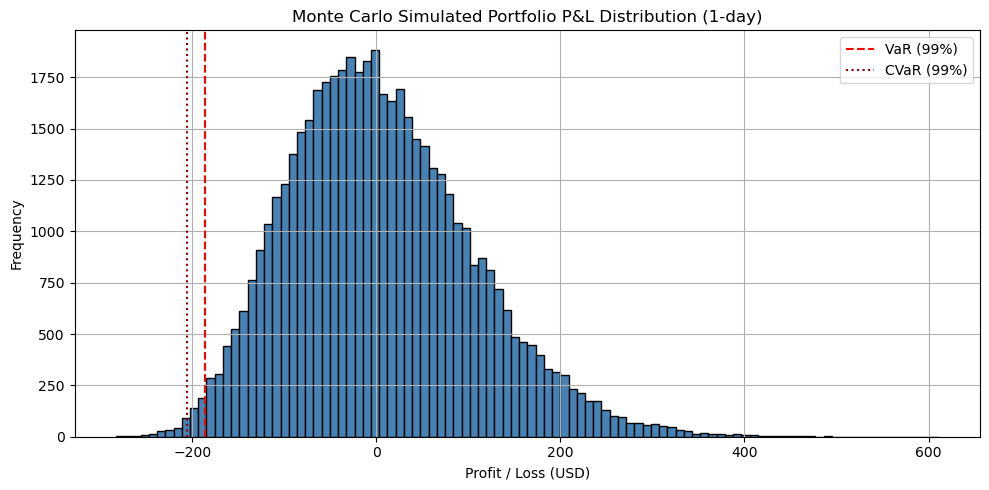

In [43]:
# Align S0 and shares to same order
tickers_ordered = list(shares_eq.index)
S0 = S0_series[tickers_ordered].values
shares_array = shares_eq[tickers_ordered].values

# Map ticker name to index for options
ticker_to_idx = {tkr: i for i, tkr in enumerate(tickers_ordered)}
for opt in options:
    opt["idx"] = ticker_to_idx[opt["idx"]]

# Run Monte Carlo Simulation (1-day horizon, 99% confidence)
var_mc, cvar_mc, pnl_mc = sim.mc_simulation_var_es(
    S0=S0,
    mu=prices.pct_change().mean()[tickers_ordered],
    cov=prices.pct_change().cov().loc[tickers_ordered, tickers_ordered],
    shares_eq=shares_array,
    options=options,
    horizon=1/252,
    alpha=0.01,
    Nsim=50_000,
    seed=42
)

# Display results
print(f"Monte Carlo VaR (99%):  {var_mc:,.2f} USD")
print(f"Monte Carlo CVaR (99%): {cvar_mc:,.2f} USD")

# Plot histogram of P&L
plt.figure(figsize=(10, 5))
plt.hist(pnl_mc, bins=100, color="steelblue", edgecolor="black")
plt.axvline(-var_mc, color="red", linestyle="--", label="VaR (99%)")
plt.axvline(-cvar_mc, color="darkred", linestyle=":", label="CVaR (99%)")
plt.title("Monte Carlo Simulated Portfolio P&L Distribution (1-day)")
plt.xlabel("Profit / Loss (USD)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Multi-Day Montecarlo Simulation

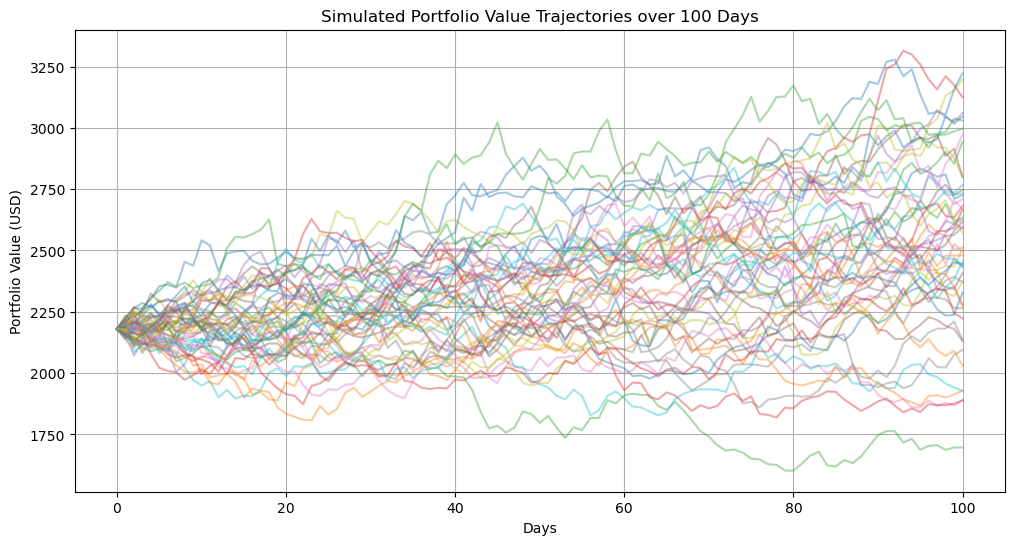

Monte Carlo 100-day VaR (99%):  556.55 USD
Monte Carlo 100-day CVaR (99%): 641.99 USD


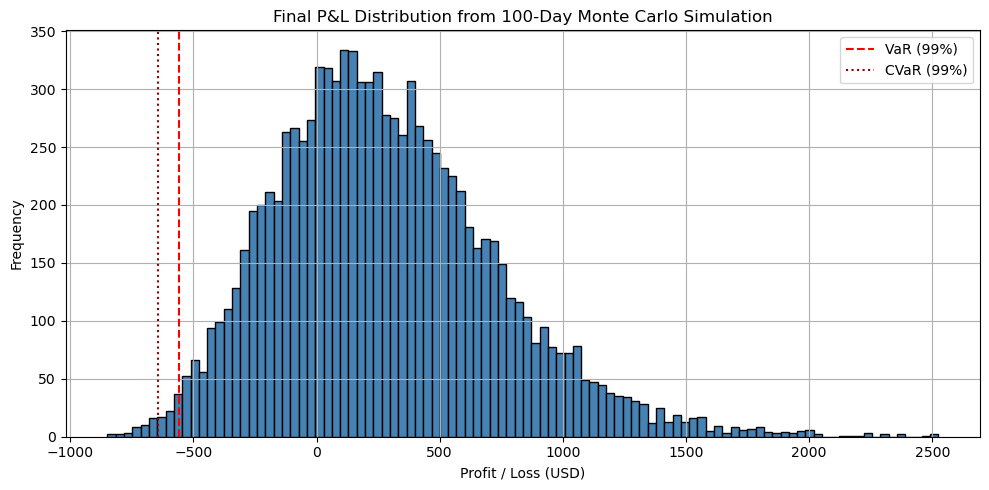

In [44]:
# Step 0: enforce correct order for all inputs
tickers_ordered = list(shares_eq.index)
S0 = S0_series[tickers_ordered].values
mu = prices.pct_change().mean()[tickers_ordered].values
cov = prices.pct_change().cov().loc[tickers_ordered, tickers_ordered].values
shares_array = shares_eq[tickers_ordered].values

# Step 1: simulate price paths for 100 days
paths = sim.simulate_price_paths(
    S0=S0,
    mu=mu,
    cov=cov,
    T_days=100,
    Nsim=10_000
)

# Step 2: compute portfolio value trajectories
portf_value_paths = (paths * shares_array).sum(axis=2)  # shape: (101, Nsim)

# Step 3: plot sample portfolio trajectories
plt.figure(figsize=(12, 6))
for i in range(50):
    plt.plot(portf_value_paths[:, i], alpha=0.4)
plt.title("Simulated Portfolio Value Trajectories over 100 Days")
plt.xlabel("Days")
plt.ylabel("Portfolio Value (USD)")
plt.grid(True)
plt.show()

# Step 4: compute VaR/CVaR from simulated paths
var_mc, cvar_mc, pnl_mc = sim.var_from_simulated_paths(paths, shares_array, alpha=0.01)

print(f"Monte Carlo 100-day VaR (99%):  {var_mc:,.2f} USD")
print(f"Monte Carlo 100-day CVaR (99%): {cvar_mc:,.2f} USD")

# Step 5: plot final P&L distribution
plt.figure(figsize=(10, 5))
plt.hist(pnl_mc, bins=100, color="steelblue", edgecolor="black")
plt.axvline(-var_mc, color="red", linestyle="--", label="VaR (99%)")
plt.axvline(-cvar_mc, color="darkred", linestyle=":", label="CVaR (99%)")
plt.title("Final P&L Distribution from 100-Day Monte Carlo Simulation")
plt.xlabel("Profit / Loss (USD)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
